In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Aquire the data.
data = pd.read_csv("main_result.tsv.txt", delimiter = '\t')

In [4]:
# Filter out everything that isn't the STRING network or auPRC score type.
data1 = data[data["Score Type"] == "auPRC"]
data1 = data1[data1["Network"] == "STRING"]

In [5]:
# Set the colors based on which geneset collection they belong to.
data2 = data1.copy()
data2["Color"] = data2["Geneset Collection"]
data2["Color"].replace({"KEGGBP" : "GOBP", "DisGeNet" : "BeFree", "GWAS" : "MGI", "GOBPtmp" : np.NaN}, inplace = True)
data2.replace({"SL-I" : np.NaN, "SL-E" : np.NaN, "LP-A" : np.NaN}, inplace = True)
data2["Color"].replace({"BeFree" : "Blue", "GOBP" : "Red", "MGI" : "Black"}, inplace = True)
data2.dropna(inplace = True)

In [6]:
# These files are the network properties for the network and geneset collections.
# They have the columns Geneset, Number of Genes, Edge Density, Segregation
BeFree = pd.read_csv("BeFree_STRING.tsv", delimiter = '\t')
DisGeNet = pd.read_csv("DisGeNet_STRING.tsv", delimiter = '\t')
GOBP = pd.read_csv("GOBP_STRING.tsv", delimiter = '\t')
GWAS = pd.read_csv("GWAS_STRING.tsv", delimiter = '\t')
KEGGBP = pd.read_csv("KEGGBP_STRING.tsv", delimiter = '\t')
MGI = pd.read_csv("MGI_STRING.tsv", delimiter = '\t')

x_dict = {'MGI' : MGI, 'GOBP' : GOBP, 'BeFree' : BeFree, 'DisGeNet' : DisGeNet, 'GWAS' : GWAS, 'KEGGBP' : KEGGBP}

In [7]:
# At this point, data2 has a lot of repeats of Genesets. We take the mean of these to remove repeats.
data3 = data2.groupby(["Geneset","Geneset Collection","Method", "Color"], as_index = False)
data4 = data3.mean()

In [11]:
# This code checks to make sure there is a network properties entry for each Genset Collection
# It isn't necesarry, but it will give you an error if you are missing the network properties for
# one of the genset collections.
for name in data4["Geneset Collection"].unique():
    x_dict[name]

In [18]:
def get_genes(Geneset, Collection, column):
    df = x_dict[Collection]
    return df[df['Geneset'] == Geneset][column].values[0]

variables = ["Number of Genes", "Edge Density", "Segregation"]

# This applies a lambda for three columns that gets the network properties for each of
# Number of Genes, Edge Desnity, and Segregation. This takes into account the different
# Genset collections.
for v in variables:
    data4[v] = data4.apply(lambda x: get_genes(x['Geneset'],x['Geneset Collection'], v) , axis = 1)

In [20]:
# At this point in the code, data4 has 'Geneset', 'Geneset Collection', 'Method', 'Color', 'Score',
#'Number of Genes', 'Edge Density', 'Segregation'.
# This is the most basic dataframe to be used for representing results. Everything before this can
# Be considered preprocessing.

Index(['Geneset', 'Geneset Collection', 'Method', 'Color', 'Score',
       'Number of Genes', 'Edge Density', 'Segregation'],
      dtype='object')

In [21]:
# A function for a future lambda expression. It can be shortened, but
# it isn't broken and it is currently easy to understand what it does.
# (it bins the data into 10 bins based on the network property.)
def my_bin(x):
    # If I have time I will changed this into a for loop.
    # Psudo code:
    # for i in range 1-9, if <= .quantile(1/i) return i.  return 10.
    if x <= data5[prop].quantile(.1):
        return 1
    if x <= data5[prop].quantile(.2):
        return 2
    if x <= data5[prop].quantile(.3):
        return 3
    if x <= data5[prop].quantile(.4):
        return 4
    if x <= data5[prop].quantile(.5):
        return 5
    if x <= data5[prop].quantile(.6):
        return 6
    if x <= data5[prop].quantile(.7):
        return 7
    if x <= data5[prop].quantile(.8):
        return 8
    if x <= data5[prop].quantile(.9):
        return 9
    else:
        return 10
    

In [22]:
# NOTE: this cell takes a little bit to run. (not that long though, unless your computer is bad)
# Create an empty dataframe with these columns so I can append to it.
binned_df = pd.DataFrame(columns = ['Bin', 'Score', 'Number of Genes', 'Edge Density',
                                    'Segregation', 'Prop', 'Color', 'Method', 'Negative Error',
                                    'Positive Error'])

# Goes over each combination of Method, Color, and Network Property and bins the data
# into 10 quantiles and appends it to the 'binned_df' dataframe.
# This will be the final dataframe for showing the data.
for method in data4['Method'].unique():
    for color in data4["Color"].unique():
        mask = np.logical_and(data4['Method'] == method, data4['Color'] == color)
        for prop in ["Number of Genes", "Edge Density", "Segregation"]:
            data5 = data4[mask]
            data5["Bin"] = data5[prop].apply(my_bin)
            data6 = data5.groupby("Bin", as_index = False).mean()
            
            # Error bars
            data6["Negative Error"] = data6["Score"] - data5.groupby("Bin", as_index = False).quantile(.25)["Score"]
            data6["Positive Error"] = data5.groupby("Bin", as_index = False).quantile(.75)["Score"] - data6["Score"]
            # Given time, I will comment these two out, copy them below, and replace .quantile with my own custom
            # function that will bootstrap it for me.
            
            # Important data for plotting 
            data6["Prop"] = prop
            data6["Color"] = color
            data6["Method"] = method
            
            binned_df = binned_df.append(data6)
# IDK what the warning is talking about. It still runs for me anyhow.

C:\Users\alder\AppData\Local\Temp/ipykernel_2140/3481824956.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data5["Bin"] = data5[prop].apply(my_bin)
C:\Users\alder\AppData\Local\Temp/ipykernel_2140/3481824956.py:19: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  data6["Negative Error"] = data6["Score"] - data5.groupby("Bin", as_index = False).quantile(.25)["Score"]
C:\Users\alder\AppData\Local\Temp/ipykernel_2140/3481824956.py:20: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before ca

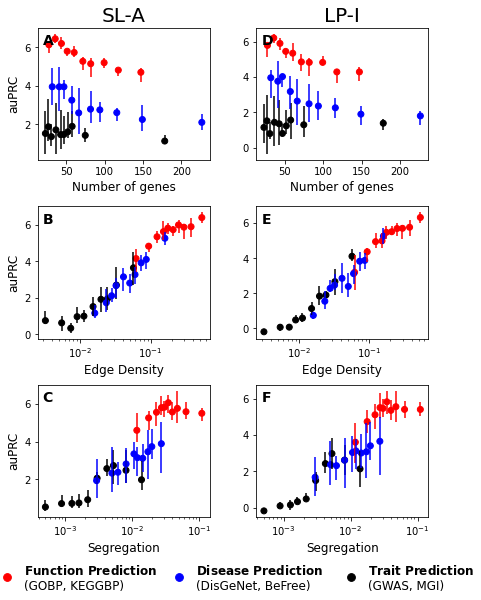

In [21]:
# Figure 5
def create_figure_5():
    # Text Parameters
    title_text = {'fontsize': 20,
                 'color': 'black'}
    axis_text = {'fontsize' : 12,
                'color' : 'black'}
    lettering = {'fontsize': 14,
                'color' : 'black',
                'weight' : 'bold'}

    fig = plt.figure(figsize = (7,9))
    plt.subplots_adjust(hspace=.35, wspace=.27)
    
    # Subplots
    ax1 = fig.add_subplot(3,2,1)
    ax2 = fig.add_subplot(3,2,2)
    ax3 = fig.add_subplot(3,2,3)
    ax4 = fig.add_subplot(3,2,4)
    ax5 = fig.add_subplot(3,2,5)
    ax6 = fig.add_subplot(3,2,6)
    
    # Titles
    ax1.title.set_text("SL-A")
    ax1.title.update(title_text)
    ax2.title.set_text("LP-I")
    ax2.title.update(title_text)
    
    # Axis labels
    ax1.xaxis.label.set_text("Number of genes")
    ax1.xaxis.label.update(axis_text)
    ax2.xaxis.label.set_text("Number of genes")
    ax2.xaxis.label.update(axis_text)
    ax3.xaxis.label.set_text("Edge Density")
    ax3.xaxis.label.update(axis_text)
    ax4.xaxis.label.set_text("Edge Density")
    ax4.xaxis.label.update(axis_text)
    ax5.xaxis.label.set_text("Segregation")
    ax5.xaxis.label.update(axis_text)
    ax6.xaxis.label.set_text("Segregation")
    ax6.xaxis.label.update(axis_text)
    ax1.yaxis.label.set_text("auPRC")
    ax1.yaxis.label.update(axis_text)
    ax3.yaxis.label.set_text("auPRC")
    ax3.yaxis.label.update(axis_text)
    ax5.yaxis.label.set_text("auPRC")
    ax5.yaxis.label.update(axis_text)
    
    # Set logs
    ax3.set_xscale("log")
    ax4.set_xscale("log")
    ax5.set_xscale("log")
    ax6.set_xscale("log")
    
    # Ticks
    # Setting the ticks was mostly so I could tell how close I was to the
    # Actual figure. Now it's probably unnecessary. I had to comment out the
    # ticks for ax1 and ax2 since it ended up being significantly different.
    #ax1.xaxis.set_ticks([50,100,150])
    #ax2.xaxis.set_ticks([50,100,150])
    ax3.xaxis.set_ticks([10**-2, 10**-1])
    ax4.xaxis.set_ticks([10**-2, 10**-1])
    ax5.xaxis.set_ticks([10**-3, 10**-2, 10**-1])
    ax6.xaxis.set_ticks([10**-3, 10**-2, 10**-1])
    ax1.yaxis.set_ticks([0,2,4,6])
    ax2.yaxis.set_ticks([0,2,4,6])
    ax3.yaxis.set_ticks([0,2,4,6])
    ax4.yaxis.set_ticks([0,2,4,6])
    ax5.yaxis.set_ticks([0,2,4,6])
    ax6.yaxis.set_ticks([0,2,4,6])
    
    # Lettering
    ax1.text(.03,.87, "A", lettering, transform=ax1.transAxes)
    ax3.text(.03,.87, "B", lettering, transform=ax3.transAxes)
    ax5.text(.03,.87, "C", lettering, transform=ax5.transAxes)
    ax2.text(.03,.87, "D", lettering, transform=ax2.transAxes)
    ax4.text(.03,.87, "E", lettering, transform=ax4.transAxes)
    ax6.text(.03,.87, "F", lettering, transform=ax6.transAxes)
    
    # Legend
    ax6.scatter(-1.45, -.45, s=60, color='red', transform=ax6.transAxes).set_clip_on(False)
    ax6.scatter(-1.45 + 1, -.45, s=60, color='blue', transform=ax6.transAxes).set_clip_on(False)
    ax6.scatter(-1.45 + 2, -.45, s=60, color='black', transform=ax6.transAxes).set_clip_on(False)
    ax6.text(-1.45 + .1, -.45 - .1, "$\\bfFunction\ Prediction$\n(GOBP, KEGGBP)", fontsize=12, transform = ax6.transAxes)
    ax6.text(-1.45 + .1 + 1, -.45 - .1, "$\\bfDisease\ Prediction$\n(DisGeNet, BeFree)", fontsize=12, transform = ax6.transAxes)
    ax6.text(-1.45 + .1 + 2, -.45 - .1, "$\\bfTrait\ Prediction$\n(GWAS, MGI)", fontsize=12, transform = ax6.transAxes)

    # Add data
    """
    m1 = data4['Method'] == 'SL-A'
    m2 = data4['Method'] == 'LP-I'
    
    data5 = data4[m1]
    
    # Old code. Generates the the figure without being binned. If you uncomment this section,
    # Make sure to comment out the binned data section.
    
    ax1.scatter(data4[m1]["Number of Genes"], data4[m1]["Score"], color = data4[m1]["Color"])
    ax2.scatter(data4[m2]["Number of Genes"], data4[m2]["Score"], color = data4[m2]["Color"])
    ax3.scatter(data4[m1]["Edge Density"], data4[m1]["Score"], color = data4[m1]["Color"])
    ax4.scatter(data4[m2]["Edge Density"], data4[m2]["Score"], color = data4[m2]["Color"])
    ax5.scatter(data4[m1]["Segregation"], data4[m1]["Score"], color = data4[m1]["Color"])
    ax6.scatter(data4[m2]["Segregation"], data4[m2]["Score"], color = data4[m2]["Color"]) 
    """
    ## Plotting the binned data
    
    # This chuck sets the masks for each of the subplots
    m1 = np.logical_and(binned_df["Method"] == "SL-A", binned_df["Prop"] == "Number of Genes")
    m2 = np.logical_and(binned_df["Method"] == "LP-I", binned_df["Prop"] == "Number of Genes")
    m3 = np.logical_and(binned_df["Method"] == "SL-A", binned_df["Prop"] == "Edge Density")
    m4 = np.logical_and(binned_df["Method"] == "LP-I", binned_df["Prop"] == "Edge Density")
    m5 = np.logical_and(binned_df["Method"] == "SL-A", binned_df["Prop"] == "Segregation")
    m6 = np.logical_and(binned_df["Method"] == "LP-I", binned_df["Prop"] == "Segregation")
    
    # This chunk of code plots the error bars for each point. Since there isn't a argument to set the color of the
    # point seperately for each one since this is primarily for plotting lines, I removed the dot a replotted it.
    ax1.errorbar(binned_df[m1]["Number of Genes"], binned_df[m1]["Score"], ls='', ecolor = binned_df[m1]["Color"], yerr=(binned_df[m1]["Positive Error"], binned_df[m1]["Negative Error"]))
    ax2.errorbar(binned_df[m2]["Number of Genes"], binned_df[m2]["Score"], ls='', ecolor = binned_df[m2]["Color"], yerr=(binned_df[m2]["Positive Error"], binned_df[m2]["Negative Error"]))
    ax3.errorbar(binned_df[m3]["Edge Density"], binned_df[m3]["Score"], ls='', ecolor = binned_df[m3]["Color"], yerr=(binned_df[m3]["Positive Error"], binned_df[m3]["Negative Error"]))
    ax4.errorbar(binned_df[m4]["Edge Density"], binned_df[m4]["Score"], ls='', ecolor = binned_df[m4]["Color"], yerr=(binned_df[m4]["Positive Error"], binned_df[m4]["Negative Error"]))
    ax5.errorbar(binned_df[m5]["Segregation"], binned_df[m5]["Score"], ls='', ecolor = binned_df[m5]["Color"], yerr=(binned_df[m5]["Positive Error"], binned_df[m5]["Negative Error"]))
    ax6.errorbar(binned_df[m6]["Segregation"], binned_df[m6]["Score"], ls='', ecolor = binned_df[m6]["Color"], yerr=(binned_df[m6]["Positive Error"], binned_df[m6]["Negative Error"]))
    
    # This plots the dot for each point without the error bar.
    ax1.scatter(binned_df[m1]["Number of Genes"], binned_df[m1]["Score"], color = binned_df[m1]["Color"])
    ax2.scatter(binned_df[m2]["Number of Genes"], binned_df[m2]["Score"], color = binned_df[m2]["Color"])
    ax3.scatter(binned_df[m3]["Edge Density"], binned_df[m3]["Score"], color = binned_df[m3]["Color"])
    ax4.scatter(binned_df[m4]["Edge Density"], binned_df[m4]["Score"], color = binned_df[m4]["Color"])
    ax5.scatter(binned_df[m5]["Segregation"], binned_df[m5]["Score"], color = binned_df[m5]["Color"])
    ax6.scatter(binned_df[m6]["Segregation"], binned_df[m6]["Score"], color = binned_df[m6]["Color"])
    
    
    plt.savefig("figure_5.png")
    plt.show(fig)

    
create_figure_5()